<a href="https://colab.research.google.com/github/abhilb/Open-eye-closed-eye-classification/blob/main/Part2/MRL_Dataset_CNN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from pathlib import Path
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Softmax, InputLayer, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
!gdown https://drive.google.com/uc?id=1JkdFa4fj0DMrDHju7QqC4EiUfJD9Cjws

Downloading...
From: https://drive.google.com/uc?id=1JkdFa4fj0DMrDHju7QqC4EiUfJD9Cjws
To: /content/mrl_dataset.npz
696MB [00:03, 183MB/s]


In [21]:
dataset_path = Path('mrl_dataset.npz').absolute().resolve()
data = np.load(str(dataset_path))
X = data['data']
y = data['labels']
data.close()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f"Number of samples in training dataset: {X_train.shape[0]}")
print(f"Number of samples in testing dataset : {X_test.shape[0]}")

Number of samples in training dataset: 56881
Number of samples in testing dataset : 28017


In [23]:
model = Sequential()
model.add(InputLayer(input_shape=(32, 32, 1)))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.5))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Softmax())

In [24]:
opt = Adam(learning_rate=0.0001)
loss = SparseCategoricalCrossentropy()
metrics = ['accuracy']
callback = EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
dropout_7 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
dropout_8 (Dropout)          (None, 11, 11, 32)       

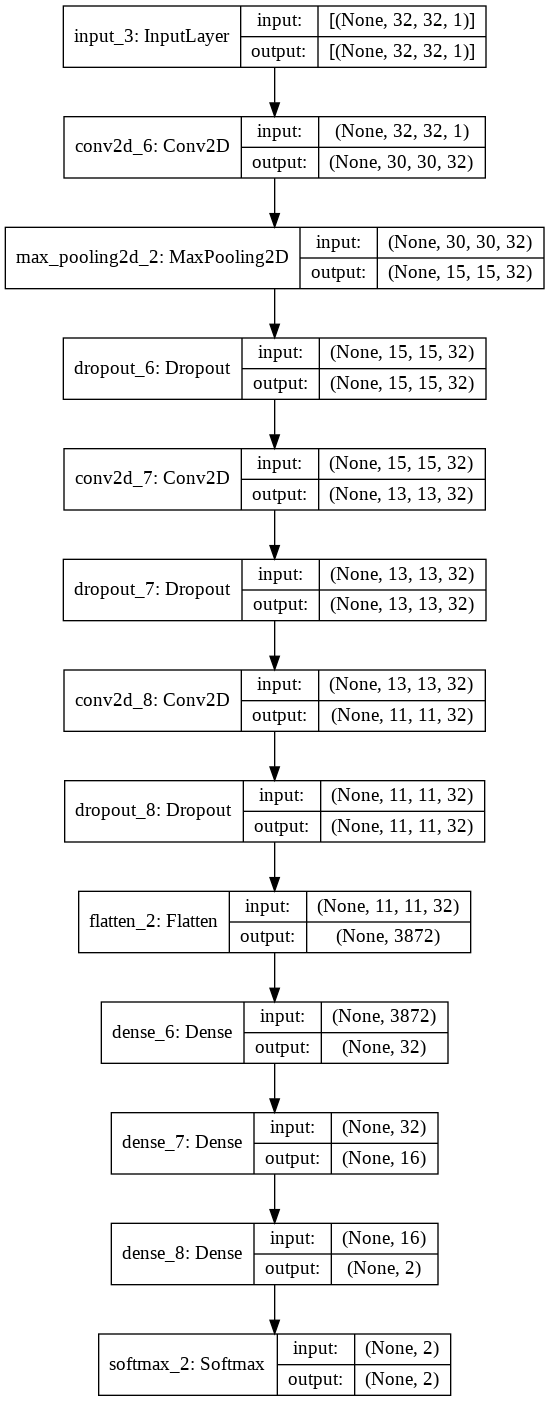

In [26]:
plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [27]:
from tensorflow.keras.utils import Sequence
from typing import Tuple

class DataGenerator(Sequence):
  def __init__(self, batch_size: int,
               dims: Tuple[int, int],
               data, labels):
    self.batch_size = batch_size
    self.dims = dims
    self.data = np.hstack((data, labels))
    self.nb_samples = self.data.shape[0]
    self.indexes = np.arange(self.nb_samples)
    self.on_epoch_end()

  def __len__(self):
    return self.nb_samples // self.batch_size

  def __getitem__(self, index):
    start_idx = index * self.batch_size
    end_idx = (index + 1) * self.batch_size
    data_slice = self.data[start_idx:end_idx, :]
    X = data_slice[:,0:-1].reshape(-1,*self.dims)
    y = data_slice[:,-1]
    return X, y

  def on_epoch_end(self):
    np.random.shuffle(self.data)


In [28]:
train_generator = DataGenerator(64, (32, 32, 1), X_train[:40000,:], y_train[:40000])
valid_generator = DataGenerator(32, (32, 32, 1), X_train[40000:,:], y_train[40000:])

history = model.fit(train_generator, validation_data=valid_generator, epochs=10)

Epoch 1/10
625/625 [==============================] - 58s 92ms/step - loss: 0.5798 - accuracy: 0.7361 - val_loss: 0.5030 - val_accuracy: 0.8575
Epoch 2/10
625/625 [==============================] - 58s 93ms/step - loss: 0.4978 - accuracy: 0.8552 - val_loss: 0.4918 - val_accuracy: 0.8682
Epoch 3/10
625/625 [==============================] - 59s 94ms/step - loss: 0.4836 - accuracy: 0.8670 - val_loss: 0.4729 - val_accuracy: 0.8825
Epoch 4/10
625/625 [==============================] - 59s 94ms/step - loss: 0.4690 - accuracy: 0.8800 - val_loss: 0.4532 - val_accuracy: 0.9000
Epoch 5/10
625/625 [==============================] - 59s 94ms/step - loss: 0.4564 - accuracy: 0.8896 - val_loss: 0.4435 - val_accuracy: 0.9065
Epoch 6/10
625/625 [==============================] - 59s 94ms/step - loss: 0.4475 - accuracy: 0.8979 - val_loss: 0.4380 - val_accuracy: 0.9142
Epoch 7/10
625/625 [==============================] - 59s 94ms/step - loss: 0.4414 - accuracy: 0.9045 - val_loss: 0.4302 - val_accuracy:

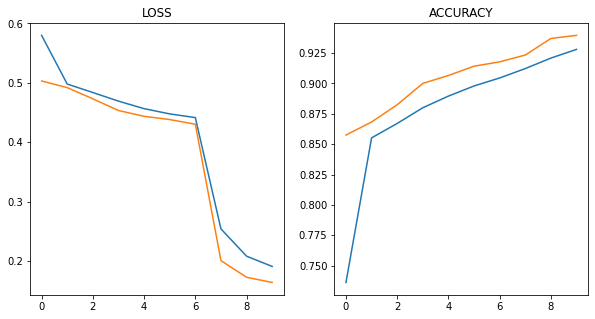

In [29]:
figure, axes = plt.subplots(1, 2)
figure.set_size_inches((10, 5))
epochs = np.arange(len(history.history['loss']))
axes[0].plot(epochs, history.history['loss'])
axes[0].plot(epochs, history.history['val_loss'])
axes[0].set_title("LOSS")

axes[1].plot(epochs, history.history['accuracy'])
axes[1].plot(epochs, history.history['val_accuracy'])
axes[1].set_title("ACCURACY")

plt.show()